In [1]:
#!/usr/bin/env python
# coding: utf-8

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
from io import BufferedReader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import classification_report, confusion_matrix
import pickle

start_time = time.time()

plt.ion()

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = "weed_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                           transform=data_transforms[x])
                 for x in ["train", "val", "test"]}
temp = image_datasets["train"]
# print("-----------------------------", os.path.join(data_dir, "train"))  
print("-----------------------------", temp[0])       
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                              shuffle=True, num_workers=4)
              for x in ["train", "val", "test"]}



dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val", "test"]}
class_names = image_datasets["train"].classes

print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#device = torch.device("cpu")

----------------------------- (tensor([[[-1.4158, -1.3302, -1.3473,  ..., -0.4739, -0.4739, -0.4568],
         [-1.4500, -1.5699, -1.5699,  ..., -0.4568, -0.4739, -0.4226],
         [-1.3987, -1.3815, -1.1589,  ..., -0.4226, -0.3883, -0.3369],
         ...,
         [-0.2513, -0.5253, -0.9705,  ..., -1.6213, -1.6555, -1.5357],
         [-0.2684, -0.4739, -0.9534,  ..., -1.3302, -1.3987, -1.4672],
         [-0.3027, -0.3883, -0.8164,  ..., -1.2445, -1.2617, -1.2788]],

        [[-1.3704, -1.2829, -1.3004,  ...,  0.3803,  0.3803,  0.3978],
         [-1.4580, -1.5455, -1.5455,  ...,  0.3978,  0.3803,  0.4328],
         [-1.4405, -1.3880, -1.1604,  ...,  0.4328,  0.4678,  0.5203],
         ...,
         [ 0.3277,  0.0476, -0.2675,  ..., -1.7031, -1.6681, -1.4580],
         [ 0.2927,  0.0651, -0.3375,  ..., -1.5805, -1.5805, -1.5980],
         [ 0.0126,  0.1176, -0.2675,  ..., -1.4930, -1.5105, -1.5280]],

        [[-1.2467, -1.1421, -1.1596,  ..., -0.4973, -0.5147, -0.4798],
         [-1.3

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []
      
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)
        t0 = time.time()
        
        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()  # set model to training mode
            else:
                model.eval()  # set model to evaulate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Interate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training mode
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(
                phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == "val":
                val_loss.append(epoch_loss)
                val_acc.append(float(epoch_acc.to("cpu").numpy()))
            else:
                train_loss.append(epoch_loss)
                train_acc.append(float(epoch_acc.to("cpu").numpy()))
        print('{} seconds'.format(time.time() - t0))
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    with open('./accuracy.pkl', 'wb') as f:
        pickle.dump({
            "training": train_acc,
            "validation": val_acc
        }, f)
    with open('./loss.pkl', 'wb') as f:
        pickle.dump({
            "training": train_loss,
            "validation": val_loss
        }, f)

    torch.save(model, 'weed_data.pth')

    return model

In [52]:
# Load a pretrained model and reset final fully connected layer

# for vgg16
# model_ft = models.vgg16(pretrained=True)
# num_ftrs = model_ft.classifier[0].out_features

# for resnet 18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# for inception
# model_ft = models.inception_v3(pretrained=True)
# num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [53]:
from torchsummary import summary
summary(model_ft, input_size=(3, 300, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           9,408
       BatchNorm2d-2         [-1, 64, 150, 150]             128
              ReLU-3         [-1, 64, 150, 150]               0
         MaxPool2d-4           [-1, 64, 75, 75]               0
            Conv2d-5           [-1, 64, 75, 75]          36,864
       BatchNorm2d-6           [-1, 64, 75, 75]             128
              ReLU-7           [-1, 64, 75, 75]               0
            Conv2d-8           [-1, 64, 75, 75]          36,864
       BatchNorm2d-9           [-1, 64, 75, 75]             128
             ReLU-10           [-1, 64, 75, 75]               0
       BasicBlock-11           [-1, 64, 75, 75]               0
           Conv2d-12           [-1, 64, 75, 75]          36,864
      BatchNorm2d-13           [-1, 64, 75, 75]             128
             ReLU-14           [-1, 64,

In [54]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 1.0158 Acc: 0.5370
val Loss: 0.4942 Acc: 0.8352
7.100767612457275 seconds

Epoch 1/19
----------
train Loss: 0.5231 Acc: 0.8222
val Loss: 0.2784 Acc: 0.9121
6.805584192276001 seconds

Epoch 2/19
----------
train Loss: 0.3798 Acc: 0.8333
val Loss: 0.1893 Acc: 0.9121
7.0894999504089355 seconds

Epoch 3/19
----------
train Loss: 0.7761 Acc: 0.7556
val Loss: 0.2012 Acc: 0.9231
7.018364429473877 seconds

Epoch 4/19
----------
train Loss: 0.4183 Acc: 0.8370
val Loss: 0.1102 Acc: 0.9560
6.483587265014648 seconds

Epoch 5/19
----------
train Loss: 0.4511 Acc: 0.8370
val Loss: 0.1391 Acc: 0.9560
7.1598289012908936 seconds

Epoch 6/19
----------
train Loss: 0.4027 Acc: 0.8593
val Loss: 0.1451 Acc: 0.9451
6.829798698425293 seconds

Epoch 7/19
----------
train Loss: 0.1791 Acc: 0.9333
val Loss: 0.0950 Acc: 0.9560
6.742856740951538 seconds

Epoch 8/19
----------
train Loss: 0.3037 Acc: 0.8741
val Loss: 0.1008 Acc: 0.9560
6.944694995880127 seconds

Epoch 9/19
------

In [55]:
# save model
PATH = 'model-resnet18-final.h5'
torch.save(model_ft, PATH)

In [56]:
# Confusion matrix
def print_confusion_matrix(model):
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = np.reshape(preds, (len(preds), 1))
            labels = np.reshape(labels, (len(preds), 1))
            for i in range(len(preds)):
                pred.append(class_names[int(preds[i])])
                true.append(class_names[int(labels[i])])
    with open('./preds.pkl', 'wb') as f:
        pickle.dump({
            "true": true,
            "pred": pred,
            "classes": class_names
        }, f)

    
    print(classification_report(true, pred, class_names))
    return confusion_matrix(true, pred, class_names)

cm = print_confusion_matrix(model_ft)

              precision    recall  f1-score   support

   cocklebur       1.00      1.00      1.00        17
     foxtail       0.88      1.00      0.93        14
     pigweed       0.97      0.97      0.97        34
     ragweed       0.95      0.87      0.91        23

    accuracy                           0.95        88
   macro avg       0.95      0.96      0.95        88
weighted avg       0.96      0.95      0.95        88



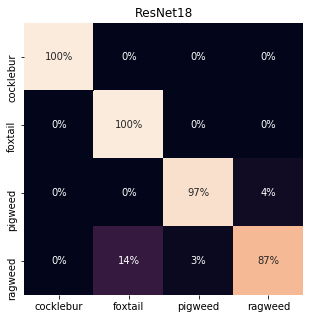

In [57]:
# for plots et al.
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

row_sums = cm.sum(axis=1)
cm = cm / row_sums

df_cm = pd.DataFrame(cm, index = ['cocklebur','foxtail','pigweed','ragweed'], columns = ['cocklebur','foxtail','pigweed','ragweed'])
# print(df_cm)

# flights = df_cm.pivot("month", "year", "passengers")

plt.figure(figsize = (5,5))
plt.title('ResNet18')
sn.heatmap(df_cm, annot=True, fmt='0.0%', cbar=False)
plt.savefig('ResNet18.png')